# A/B test

# Описание проекта

Провести A/B тестирование. Есть данные, необходимо с ними поработать.

# Цель проекта

проверить полученные знания на практике и решить аналитический кейс

# Описание данных

Есть три датасета. 
1. hypothesis.csv - хранит гипотезы теста, 
2. orders.csv — информацию о заказах, 
3. visitors.csv — информацию о посетителях.

Структура hypothesis.csv:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура orders.csv:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Структура visitors.csv:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# План работы

1. Посмотреть данные
2. Приоритезировать гипотезы
3. Анализ А/В теста
4. Рекомендации для компании

# Загрузка данных и подготовка к анализу

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from itertools import cycle
import os
from IPython.display import display_html

import scipy.stats as stats
import datetime as dt

## Дополнительные настройки

In [2]:
pd.set_option('display.max_colwidth', 0)

## Формирование функций

In [3]:
def missing_values(df):
    """Вычисление аномалий в датасете, включая минимальные и максимальные значения"""    
    data = pd.DataFrame(columns=['NaN_part', 'empty_counts', 'space_counts', '0_counts', 'unique_counts',\
                                          'min_value', 'max_value', 'dupl_sum', 'dtypes', 'length'], index=df.columns)
    for column in df.columns:
        data['NaN_part'][column] = df[column].isnull().mean()
        data['empty_counts'][column] = df[df[column] == ''][column].count()
        data['space_counts'][column] = df[df[column] == ' '][column].count()
        data['0_counts'][column] = df[df[column] == 0][column].count()
        data['unique_counts'][column] = len(df[column].unique())
        data['min_value'][column] = df[column].min()
        data['max_value'][column] = df[column].max()
        data['dupl_sum'][column] = df[column].duplicated().sum()
        data['dtypes'][column] = df[column].dtypes
        data['length'][column] = len(df[column])
    return data 

In [4]:
def display_side_by_side(*args, titles=cycle([''])):
    html_str = ''
    for df, title in zip(args, titles):
        html_str += '<td style="vertical-align:top">'
        html_str += f'<h3><center>{title}<center></h3>'
        html_str += df.to_html()
    display_html(html_str, raw=True)

In [5]:
def cumulative_calculation(cumulativeData, flag=0):
    # датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в группах
    cumulativeA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders', 'visitors']]
    cumulativeB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders', 'visitors']]
    
    # датафреймы с средним чеком по группам
    cumulativeRevenueA_mean_bill = cumulativeA['revenue'] / cumulativeA['orders']
    cumulativeRevenueB_mean_bill = cumulativeB['revenue'] / cumulativeB['orders']
    
    def to_calculate_relative_metrics(df, column):
        result = (df[column[0]] / df[column[1]]) / (df[column[2]] / df[column[3]]) - 1
        
        return result
    
    # датафрейм относительного различия для среднего чека
    mergedCumulativeRevenue = cumulativeA.merge(cumulativeB, on='date', suffixes=['A', 'B'])
    сumulativeRevenue = to_calculate_relative_metrics(
        mergedCumulativeRevenue, ['revenueB', 'ordersB', 'revenueA', 'ordersA']
    )
    
    # датафрейм кумулятивного среднего количества заказов на посетителя по группам
    cumulativeOrdersA_mean_count = cumulativeA['orders'] / cumulativeA['visitors']
    cumulativeOrdersB_mean_count = cumulativeB['orders'] / cumulativeB['visitors']
    
    # датафрейм относительного различия для среднего чека
    mergedCumulativeOrders = cumulativeA.merge(cumulativeB, on='date', suffixes=['A', 'B'])
    сumulativeOrders = to_calculate_relative_metrics(
        mergedCumulativeOrders, ['ordersB', 'visitorsB', 'ordersA', 'visitorsA']
    )

    plt.figure(figsize=(15, 7))
    # Строим график кумулятивной выручки по группам
    if flag == 0:
        plt.plot(cumulativeA['date'], cumulativeA['revenue'], label='A')
        plt.plot(cumulativeB['date'], cumulativeB['revenue'], label='B')
        plt.title('График кумулятивной выручки по группам')
        plt.ylabel('Кумулятивная выручка')
    # Строим график кумулятивного среднего чека по группам
    elif flag == 1:
        plt.plot(cumulativeA['date'], cumulativeRevenueA_mean_bill, label='A')
        plt.plot(cumulativeB['date'], cumulativeRevenueB_mean_bill, label='B')
        plt.title('График кумулятивного среднего чека по группам')
        plt.ylabel('Кумулятивный средний чек')
    elif flag == 2:
        # cтроим отношение кумулятивных средних чеков
        plt.plot(mergedCumulativeRevenue['date'], сumulativeRevenue)
        plt.axhline(y=0, color='black', linestyle='--')
        plt.title('График отношения кумулятивных средних чеков группы В к группе А')
        plt.ylabel('Отношение кумулятивных средних чеков')
    elif flag == 3:
        # Строим график кумулятивного среднего количества заказов на посетителя по группам
        plt.plot(cumulativeA['date'], cumulativeOrdersA_mean_count, label='A')
        plt.plot(cumulativeB['date'], cumulativeOrdersB_mean_count, label='B')
        plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
        plt.ylabel('Кумулятивное среднее количество заказов на посетителя')
    elif flag == 4:
        # cтроим отношение средних чеков
        plt.plot(mergedCumulativeOrders['date'], сumulativeOrders)
        plt.axhline(y=0, color='black', linestyle='--')
        plt.title('График отношения кумулятивных среднего количества заказов на посетителя группы В к группе А')
        plt.ylabel('Отношение кумулятивных среднего количества заказов')

    plt.xlabel('Диапазон тестирования по времени')
    plt.xticks(np.arange(min(cumulativeData['date']), max(cumulativeData['date']) + timedelta(days=1), timedelta(days=2)))
    plt.legend()
    plt.xticks(rotation=20)
    plt.grid()
    plt.show()

In [6]:
def cumulative_data(orders, visitors):
    # создаем массив уникальных пар значений дат и групп теста
    datesGroups = orders[['date','group']].drop_duplicates()

    # получаем агрегированные кумулятивные по дням данные о заказах 
    ordersAggregated = (
        datesGroups
        .apply(
            lambda x: 
                orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                .agg({
                    'date': 'max', 
                    'group': 'max', 
                    'visitorId': 'nunique', 
                    'transactionId': 'nunique', 
                    'revenue': 'sum'
                }), 
                axis=1
        )
        .sort_values(by=['date','group'])
    )

    # получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
    visitorsAggregated = (
        datesGroups
        .apply(
            lambda x: 
                visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                .agg({
                    'date' : 'max', 
                    'group' : 'max', 
                    'visitors' : 'sum'
                }), 
                axis=1
        )
        .sort_values(by=['date','group'])
    )

    # объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
    cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
    cumulativeData.columns = ['date', 'group', 'buyers', 'orders', 'revenue', 'visitors']

    display(cumulativeData.head(5))
    return cumulativeData

In [7]:
def orders_by_users(orders):
    ordersByUsersA = (
        orders[orders['group'] == 'A']
        .groupby('visitorId', as_index=False)
        .agg({'transactionId': pd.Series.nunique})
    )
    ordersByUsersA.columns = ['userId', 'orders']

    ordersByUsersB = (
        orders[orders['group'] == 'B']
        .groupby('visitorId', as_index=False)
        .agg({'transactionId': pd.Series.nunique})
    )
    ordersByUsersB.columns = ['userId', 'orders']
    return ordersByUsersA, ordersByUsersB

In [8]:
def statistical_significance(sampleA, sampleB, alpha=0.05):
    
    p_value = float("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница. p_value={}'.format(p_value))
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными. p_value={}'.format(p_value))
        
    p_value = float("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
    
    if p_value < alpha:
        print('Относительный прирост группы В к группе А < уровня значимости. p_value={}'.format(p_value))
    else:
        print('Относительный прирост группы В к группе А >= уровня значимости. p_value={}'.format(p_value))


## Загрузка и обработка данных

Загрузить данные о визитах, заказах и гипотезах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visitors.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visitors.csv);
- заказы: `/datasets/orders.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders.csv);
- гипотезы: `/datasets/hypothesis.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/hypothesis.csv).

In [9]:
data = {} 
path = '/datasets/' if os.path.isdir('/datasets/') else 'datasets/'
columns = ['hypothesis', 'orders', 'visitors']

for column in columns:
    data[column] = pd.read_csv(path + column + '.csv')
    
display_side_by_side(
    data[columns[0]].head(),
    data[columns[1]].head(),
    data[columns[2]].head(),

    titles=columns  
)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B


In [10]:
hypothesis, orders, visitors = (
    pd.read_csv(path + 'hypothesis.csv'), 
    pd.read_csv(path + 'orders.csv'),  
    pd.read_csv(path + 'visitors.csv'),  
)

In [11]:
missing_values(visitors)

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
date,0.0,0,0,0,31,2019-08-01,2019-08-31,31,object,62
group,0.0,0,0,0,2,A,B,60,object,62
visitors,0.0,0,0,0,58,361,770,4,int64,62


In [12]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [13]:
missing_values(orders)

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
transactionId,0.0,0,0,0,1197,1062393,4293855558,0,int64,1197
visitorId,0.0,0,0,0,1031,5114589,4283872382,166,int64,1197
date,0.0,0,0,0,31,2019-08-01,2019-08-31,1166,object,1197
revenue,0.0,0,0,0,713,50,1294500,484,int64,1197
group,0.0,0,0,0,2,A,B,1195,object,1197


In [14]:
orders['date'] = pd.to_datetime(orders['date'])

In [15]:
missing_values(hypothesis)

,NaN_part,empty_counts,space_counts,0_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
Hypothesis,0.0,0,0,0,9,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа","Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",0,object,9
Reach,0.0,0,0,0,6,1,10,3,int64,9
Impact,0.0,0,0,0,7,1,10,2,int64,9
Confidence,0.0,0,0,0,7,1,9,2,int64,9
Efforts,0.0,0,0,0,6,1,10,3,int64,9


In [16]:
duplicateRows = visitors[visitors.duplicated()]
print(duplicateRows)

duplicateRows = orders[orders.duplicated()]
print(duplicateRows)

duplicateRows = hypothesis[hypothesis.duplicated()]
print(duplicateRows)

Empty DataFrame
Columns: [date, group, visitors]
Index: []
Empty DataFrame
Columns: [transactionId, visitorId, date, revenue, group]
Index: []
Empty DataFrame
Columns: [Hypothesis, Reach, Impact, Confidence, Efforts]
Index: []


В моем распоряжении три датасета:
- визиты
- заказы
- гипотезы

В целом с данными в таблицах все хорошо, только перевел даты из формата строки в формат даты. Дубликатов, пропусков, пустых ячеек нет.

При проведении А/В теста полезно изучить состав групп. 

In [17]:
print(
    f"Всего {sum(visitors['visitors'])} посещений было за август 2019 года. " 
    f"Из них {len(orders['visitorId'].unique())} уникальный посетитель сделал заказ."
)

Всего 37652 посещений было за август 2019 года. Из них 1031 уникальный посетитель сделал заказ.


In [18]:
visitorsA = set(orders[(orders['group'] == 'A')]['visitorId'])
visitorsB = set(orders[(orders['group'] == 'B')]['visitorId'])
visitors_intersect = visitorsA.intersection(visitorsB)
print(visitors_intersect)

{3957174400, 3984495233, 2780786433, 1294878855, 1648269707, 1614305549, 4120364173, 232979603, 199603092, 4266935830, 2712142231, 2587333274, 2716752286, 3891541246, 1668030113, 2654030115, 3234906277, 1230306981, 1404934699, 3803269165, 2949041841, 237748145, 457167155, 2927087541, 1738359350, 3062433592, 3656415546, 818047933, 393266494, 963407295, 471551937, 2579882178, 3202540741, 2686716486, 1333886533, 2044997962, 3941795274, 1801183820, 2378935119, 4256040402, 4069496402, 3766097110, 8300375, 351125977, 1602967004, 276558944, 2038680547, 3951559397, 3963646447, 4186807279, 3717692402, 1959144690, 2458001652, 2600415354, 2954449915, 1316129916, 477780734, 3972127743}


In [19]:
print(f"Процент пересекающихся пользователей составляет {round(len(visitors_intersect)/len(orders['visitorId'].unique()) * 100, 2)} %")

Процент пересекающихся пользователей составляет 5.63 %


Оказывается, что в данных есть дублирование пользовательских id в тестируемых группах. В идеале необходимо обратиться к тому, кто отвечает за эти данные. Достаточно странным является тот факт, что некоторые пользователи оказались в обоих группах. Можно предположить, что A/A тестирование было проведено некорректно.

Что делать с пересекающимися пользовательскими id? Можно удалить, потому что сложно доверять этим данным. Но сделать это можно, если их количество не превышает 5-10%, иначе большой вопрос возникает можем ли мы в принципе проводить тестирование по большому количеству кривых данных? В нашем случае мы укладываемся в диапазон.

А есть ли пересекающиеся заказы?

In [20]:
visitorsA = set(orders[(orders['group'] == 'A') & (orders['visitorId'].isin(visitors_intersect))]['transactionId'])
visitorsB = set(orders[(orders['group'] == 'B') & (orders['visitorId'].isin(visitors_intersect))]['transactionId'])
visitors_intersect = visitorsA.intersection(visitorsB)
print(visitors_intersect)

set()


Пересекающихся заказов нет. Я так подумал, что возможно А/А тестирование могло быть все-таки корректно, надо лезть в детали.

# Приоритезация гипотез

- Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

## ICE

![Текст с описанием картинки](https://pictures.s3.yandex.net/resources/ice_score_2-27da3b9e-15cd-4f96-91a4-fefffd1d986e_1569198107.jpg)

In [21]:
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'], 1)
display(hypothesis.sort_values(by='ICE', ascending=False))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


В компании принята шкала линейной оценки гипотезы по параметру Reach от 0 до 10, где 0 — «охват гипотезы ни на кого не повлияет», а 10 — «гипотеза охватит хотя бы половину пользователей».

Параметр Impact показывает, насколько сильно изменение повлияет на охваченных пользователей. Impact измеряют по-разному:
- По доле от общей площади экрана, которую составят меняющиеся элементы, в %;
- По степени изменения пользовательского опыта;
- По предварительной оценке важности для пользователей;
- По количеству новых пользователей, которых изменение поможет привлечь.
В зависимости от продукта и стратегии вашего бизнеса можно принять для оценки Impact  и собственные, уникальные критерии.

Параметр Confidence показывает, насколько вы уверены в оценках других параметров. 
Уверенность, например, будет высокой, если:
- вы можете точно посчитать, сколько пользователей подвержено изменению;
- у вас есть доказательства, что данное изменение повлияет с тем Impact, который вы оценили (например, за счёт предыдущего опыта или кейсов конкурентов);
- у вас есть точная оценка трудозатрат, и рисков их увеличения нет, либо они низкие.

Параметр Efforts показывает, насколько сложно проверить гипотезу. В большинстве компаний на рынке разработка очень дорогая и выступает основным ресурсом. Если проверка гипотезы не требует разработки, её Efforts значительно снижается. Если разработка необходима, разумно подключить программистов к оценке объёма работы. Подойдёт любая практика, устоявшаяся внутри компании.

## RICE

![Текст с описанием картинки](https://pictures.s3.yandex.net/resources/rice_score_1634305501.png)

In [22]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
display(hypothesis.sort_values(by='RICE', ascending=False))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


## Вывод

При применении параметра ICE or RICE результат меняется линейно на величину параметра Reach. Приоритезация изменилась: там где больше параметр Reach, там выше приоритет гипотезы.

По модели ICE приоритетными оказались гипотезы №8, 0, 7. По модели RICE гипотезы №7, 2, 0. Как видно, гипотезы №7 и №0 стоит рассмотреть в первую очередь. Гипотеза №8 по модели RICE упала с 1 на 5 место.

# Анализ A/B-теста

- Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
- Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
- Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
- Примите решение по результатам теста и объясните его. Варианты решений:
    1. Остановить тест, зафиксировать победу одной из групп.
    2. Остановить тест, зафиксировать отсутствие различий между группами.
    3. Продолжить тест.

## Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [23]:
columns = ['orders', 'visitors']

display_side_by_side(
    orders.head(),
    visitors.head(),
    titles=columns  
)

orders 
 
 
 
 transactionId 
 visitorId 
 date 
 revenue 
 group 
 
 
 
 
 0 
 3667963787 
 3312258926 
 2019-08-15 
 1650 
 B 
 
 
 1 
 2804400009 
 3642806036 
 2019-08-15 
 730 
 B 
 
 
 2 
 2961555356 
 4069496402 
 2019-08-15 
 400 
 A 
 
 
 3 
 3797467345 
 1196621759 
 2019-08-15 
 9759 
 B 
 
 
 4 
 2282983706 
 2322279887 
 2019-08-15 
 2308 
 B 
 
 
 visitors 
 
 
 
 date 
 group 
 visitors 
 
 
 
 
 0 
 2019-08-01 
 A 
 719 
 
 
 1 
 2019-08-02 
 A 
 619 
 
 
 2 
 2019-08-03 
 A 
 507 
 
 
 3 
 2019-08-04 
 A 
 717 
 
 
 4 
 2019-08-05 
 A 
 756

In [24]:
cumulativeData = cumulative_data(orders, visitors)

,date,group,buyers,orders,revenue,visitors
0,2019-08-01,A,20,24,148579,719
1,2019-08-01,B,20,21,101217,713
2,2019-08-02,A,38,44,242401,1338
3,2019-08-02,B,43,45,266748,1294
4,2019-08-03,A,62,68,354874,1845


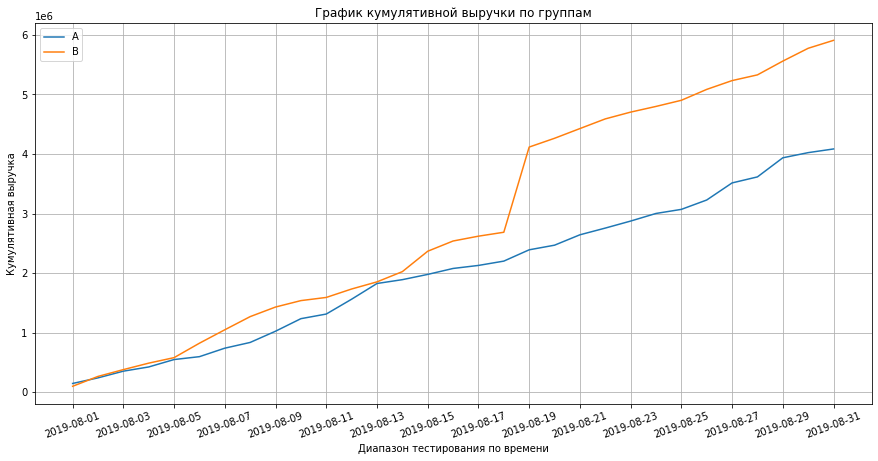

In [25]:
cumulative_calculation(cumulativeData, flag=0)

Прибыль растет в течение всего рассматриваемого периода. В группе В прибыль растет быстрее группы А на протяжении всего периода.

В некоторых точках видны всплески. Ярко заметно по группе В. Видимо выросло количество заказов или произошел аномальный всплеск. В дальнейшем нужно будет детальнее остановиться на этом моменте.

## Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

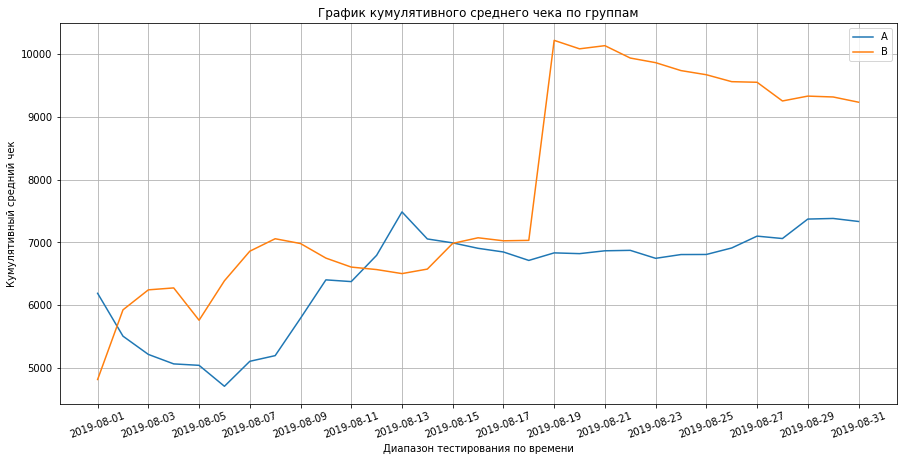

In [26]:
cumulative_calculation(cumulativeData, flag=1) 

Кумулятивный средний чек вырос неравномерно. 

Для группы А заметно падение с последующим ростом и выходом на плато. Половину периода накопление среднего чека не росло.

Для группы В другая ситуация. Первая половина периода прошла неравномерным ростом, а во второй половине произошел резкий всплеск. Это может говорить только о попадании крупного заказа. Затем средний чек падает, то есть большие поставки есть, но они стали уменьшаться.

Накопление среднего чека в обоих группах неравномерное. Необходимо больше данных для того, чтобы график среднего чека установился на определенном уровне.

## Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

No handles with labels found to put in legend.


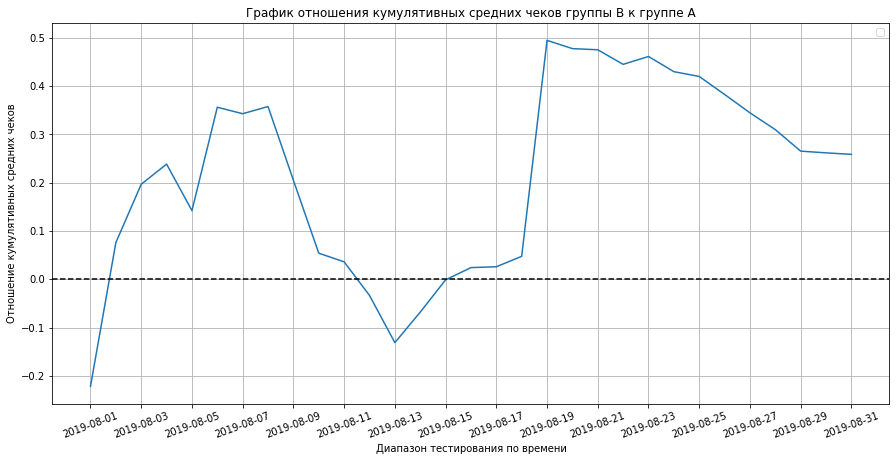

In [27]:
cumulative_calculation(cumulativeData, flag=2)

Относительное изменение кумулятивного среднего чека группы В к группе А резко скачет. Существуют большие различия по заказам между группами - есть аномалии и крупные заказы. С ними надо будет работать.

## Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

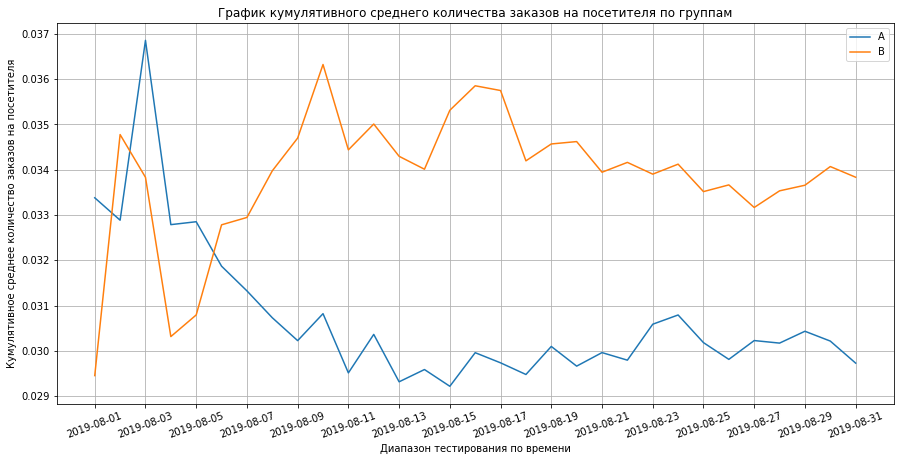

In [28]:
cumulative_calculation(cumulativeData, flag=3)

График кумулятивного среднего количества заказов на посетителя по группа отличается. Для группы А он резко падает и устаканивается на плато. 

У группы В немного другая ситуация. Видны резкие колебания в первую неделю, но затем произошла стабилизация с небольшим наклоном в сторону уменьшения среднего количества заказов на посетителя. При этом в группе В стабильно выше эта метрика относительно группы А.

Смущают резкие всплески в первую неделю. Должно быть что-то было не так с тестированием. Возможно было вмешательство каких-то внешних факторов, которые повлияли на наше исследование. 

Предполагаю, что были проблемы с А/А-тестированием, возможно выборки были неправильно подобраны.

## Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

No handles with labels found to put in legend.


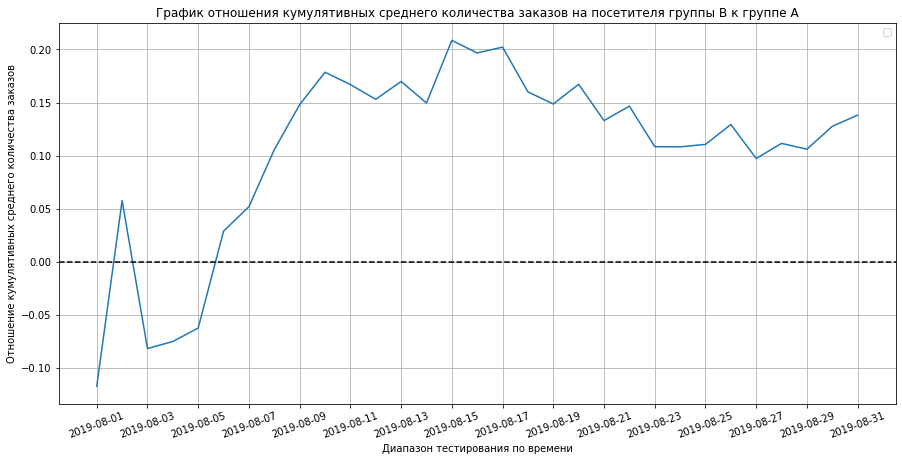

In [29]:
cumulative_calculation(cumulativeData, flag=4)

Относительное изменение кумулятивного среднего количества заказов на посетителя группы В к группе А неравномерно растет, заметен высокий рост в первую неделю. График в целом повторяет предыдущий визуал (похож).

Метрика лучше в группе В практически на всем рассматриваемом периоде, кроме первых 6 дней. К концу периода заметно снижение роста и выход на плато.

## Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [30]:
columns = ['orders', 'visitors']

display_side_by_side(
    orders.head(),
    visitors.head(),
    titles=columns  
)

orders 
 
 
 
 transactionId 
 visitorId 
 date 
 revenue 
 group 
 
 
 
 
 0 
 3667963787 
 3312258926 
 2019-08-15 
 1650 
 B 
 
 
 1 
 2804400009 
 3642806036 
 2019-08-15 
 730 
 B 
 
 
 2 
 2961555356 
 4069496402 
 2019-08-15 
 400 
 A 
 
 
 3 
 3797467345 
 1196621759 
 2019-08-15 
 9759 
 B 
 
 
 4 
 2282983706 
 2322279887 
 2019-08-15 
 2308 
 B 
 
 
 visitors 
 
 
 
 date 
 group 
 visitors 
 
 
 
 
 0 
 2019-08-01 
 A 
 719 
 
 
 1 
 2019-08-02 
 A 
 619 
 
 
 2 
 2019-08-03 
 A 
 507 
 
 
 3 
 2019-08-04 
 A 
 717 
 
 
 4 
 2019-08-05 
 A 
 756

In [31]:
orders_agg = (
    orders
    .groupby(by=['visitorId'])
    .agg({'transactionId': 'count'})
    .rename(columns={'transactionId': 'orders_cnt'})
    .reset_index()
)

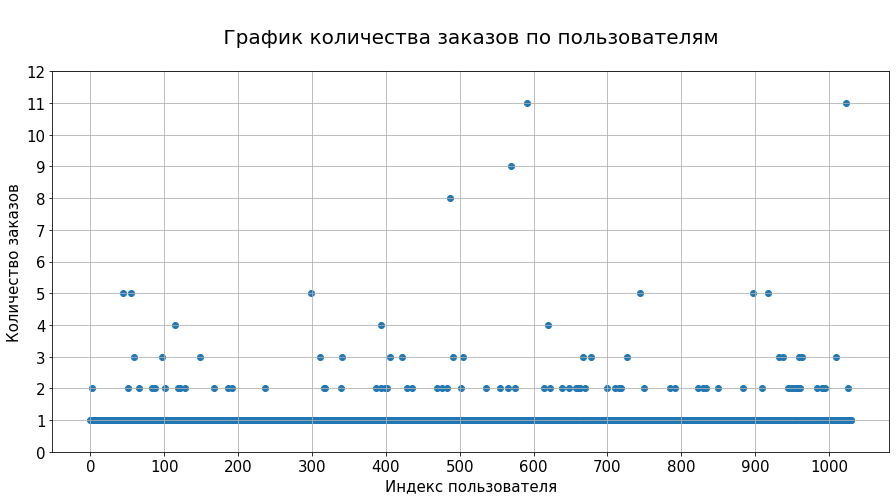

In [32]:
plt.figure(figsize=(15, 7))

x_values = pd.Series(range(0, len(orders_agg['orders_cnt'])))
plt.scatter(x_values, orders_agg['orders_cnt'])

plt.title('\n График количества заказов по пользователям \n', fontsize=20)
plt.ylabel('Количество заказов', fontsize=15)
plt.xlabel('Индекс пользователя', fontsize=15)

plt.xticks(np.arange(min(x_values), max(x_values), 100))
plt.xticks(fontsize=15)
plt.yticks(np.arange(min(orders_agg['orders_cnt']) - 1, max(orders_agg['orders_cnt']) + 2, 1))
plt.yticks(fontsize=15)
plt.grid()
plt.show()

Как и предполагалось в количестве заказов есть аномальные значения. Кто-то делал 8, 9 и даже 11 заказов. Граница отсечения по количеству заказов на графике должна располагаться где-то примерно между 3 и 4.

## Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [33]:
print(np.percentile(orders_agg['orders_cnt'], [95, 97.5, 99])) 

[2. 3. 4.]


Возьму за опорную границу 97.5%. Расчет персентиля показывает, что можно отсекать значения количества заказов, превышающих 3.

## Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

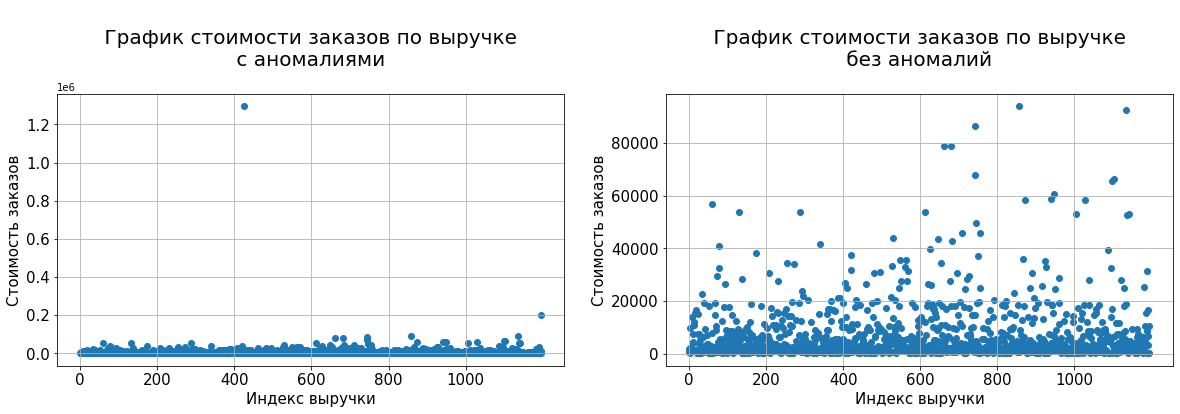

In [34]:
fig = plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1, 2, 1)

x_values = pd.Series(range(0, len(orders['revenue'])))
ax1.scatter(x_values, orders['revenue'])

plt.title('\n График стоимости заказов по выручке \n c аномалиями \n', fontsize=20)
plt.ylabel('Стоимость заказов', fontsize=15)
plt.xlabel('Индекс выручки', fontsize=15)

plt.xticks(np.arange(min(x_values), max(x_values), 200))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

ax2 = plt.subplot(1, 2, 2, sharex=ax1)

y_values = orders[orders['revenue'] < 200000]['revenue']
x_values = pd.Series(range(0, len(y_values)))

ax2.scatter(x_values, y_values)

plt.title('\n График стоимости заказов по выручке \n без аномалий \n', fontsize=20)
plt.ylabel('Стоимость заказов', fontsize=15)
plt.xlabel('Индекс выручки', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.show()

В расчете выручки так же есть экстремально аномальное значение. Оно видимо и создавало скачок метрик в группе В. Граница отсечения должна быть меньше 200 000.

## Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [35]:
print(np.percentile(orders['revenue'], [95, 97.5, 99])) 

[28000.  39530.  58233.2]


Возьму за опорную границу 97.5%. Расчет персентиля показывает, что можно отсекать значения количества заказов, превышающих 40000.

## Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.

Приму за нулевую гипотезу что различие в среднем количестве заказов на посетителя между группами по "сырым" данным статистически не значимы. Тогда альтернативная гипотеза заключается в том, что различие значимо.

Уровень значимости альфа приму α=0.05

In [36]:
ordersByUsersA, ordersByUsersB = orders_by_users(orders)

In [42]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index = np.arange(
                cumulativeData[cumulativeData['group'] == 'A']['visitors'].max() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index = np.arange(
                cumulativeData[cumulativeData['group'] == 'B']['visitors'].max() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

statistical_significance(sampleA, sampleB)

Отвергаем нулевую гипотезу: между долями есть значимая разница. p_value=0.017
Относительный прирост группы В к группе А >= уровня значимости. p_value=0.138


p_value=1.7%, это меньше заданного уровня значимости. Нулевую гипотезу отвергаем. Разница между выборками имеет значимый характер. Следовательно можно утверждать, что разница в среднем количестве заказов на посетителя между группами есть. Тот результат, который имеет на графике не может быть получен случайно.

Относительный прирост группы В по среднему количеству заказов на посетителя составил 13.8%.

## Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Приму за нулевую гипотезу что разница в среднем чеке заказа между группами по "сырым" данным статистически не значима. Тогда альтернативная гипотеза заключается в том, что разница значима.

Уровень значимости альфа α=0.05

In [38]:
sampleA = orders[orders['group']=='A']['revenue']
sampleB = orders[orders['group']=='B']['revenue']

statistical_significance(sampleA, sampleB)

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными. p_value=0.729
Относительный прирост группы В к группе А >= уровня значимости. p_value=0.259


Не получилось отвергнуть нулевую гипотезу. Разница между выборками имеет случайный характер. 

Относительный прирост группы В по среднему чеку заказа составил 26%.

## Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 40 000 рублей. Так мы уберём 2.5% пользователей с наибольшим числом заказов и 2.5% пользователей с дорогими заказами.

Сделаем срезы пользователей с числом заказов больше 3 — usersWithManyOrders и пользователей, совершивших заказы дороже 40 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [39]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
18      199603092
23      237748145
684     358944393
648     382846391
dtype: int64
34


Всего 34 аномальных userId в нашем датасете.

Приму за нулевую гипотезу что разница в среднем количестве заказов на посетителя между группами по "сырым" данным статистически не значима. Тогда альтернативная гипотеза заключается в том, что разница значима.

Уровень значимости альфа α=0.05

In [43]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                cumulativeData[cumulativeData['group'] == 'A']['visitors'].max() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                cumulativeData[cumulativeData['group'] == 'B']['visitors'].max() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

statistical_significance(sampleAFiltered, sampleBFiltered)

Отвергаем нулевую гипотезу: между долями есть значимая разница. p_value=0.009
Относительный прирост группы В к группе А >= уровня значимости. p_value=0.164


Аномалии особо не повлияли на статистическую значимость. По очищенным данным p_value уменьшился с 1.7%% до 0.9%.

Относительный прирост группы В к группе А увеличился с 13.8% до 16.4%

## Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем чеке заказа между группами теста по "очищенным" данным. Сначала подготовим выборки по группам теста:

In [41]:
sampleAFiltered = orders[
    np.logical_not(orders['visitorId'].isin(abnormalUsers)) & (orders['group'] == 'A')
]['revenue']

sampleBFiltered = orders[
    np.logical_not(orders['visitorId'].isin(abnormalUsers)) & (orders['group'] == 'B')
]['revenue']

statistical_significance(sampleAFiltered, sampleBFiltered)

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными. p_value=0.711
Относительный прирост группы В к группе А >= уровня значимости. p_value=0.06


Статистической разницы между "очищенными" и "сырыми" данными нет. p_value уменьшился с 72.9% до 71.1%

Относительный прирост группы В к группе А уменьшился с 26% до 6%

## Примите решение по результатам теста и объясните его. 

По графикам кумулятивного расчета:
- Прибыль неравномерно растет в течение всего рассматриваемого периода
- Кумулятивный средний чек вырос неравномерно
- График кумулятивного среднего количества заказов на посетителя по группам показателен. По группе А падает с выходом на плато, но на всем периоде больше стабильно растущей метрики по группе В. Это толстый намек на ошибку при А/А тестировании

Оценил наличие аномалий в данных.

Посчитал статистическую значимость различий в среднем чеке заказа между группами по «очищенным» и "сырым" данным:
- Статистической разницы между "очищенными" и "сырыми" данными нет. p_value уменьшился с 72.9% до 71.1%
- Относительный прирост группы В к группе А уменьшился с 26% до 6%

Посчитал статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» и "сырым" данным:
- Аномалии особо не повлияли на статистическую значимость. По очищенным данным p_value уменьшился с 1.7% до 0.9%
- Относительный прирост группы В к группе А увеличился с 13.8% до 16.4%

Имеющиеся факты:
- Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A, но есть небольшая тенденция к ухудшению. 
- График различия среднего чека говорит о том, что результаты группы B имеет резкие колебания в течение всего периода

По результатам исследования, можно утверждать, что различия среднего количества заказов между группами имеют статистическую значимость. То есть разница получена не случайным образом, а она действительно есть. Таким образом, количество заказов увеличилось, а средний чек остался прежним. Выручка увеличивается. 

Исходя из обнаруженных фактов, тест следует остановить и признать успешным. 